In [1]:
%matplotlib notebook

In [2]:
import matplotlib as mpl
mpl.get_backend()

'nbAgg'

In [106]:

# yellowbrick.features.scatterplotmatrix
# Implementations of joint plots for univariate and bivariate analysis.
#
# Author:   Prema Damodaran Roman 
# Created:  
#
# Copyright (C) 2017 District Data Labs
# For license information, see LICENSE.txt
#
# ID: scatterplotmattix.py

##########################################################################
## Imports
##########################################################################
#from matplotlib.backends.backend_agg import FigureCanvasAgg

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from yellowbrick.features.base import DataVisualizer
from yellowbrick.exceptions import YellowbrickValueError
from yellowbrick.bestfit import draw_best_fit
from yellowbrick.utils import is_dataframe

class ScatterPlotMatrixVisualizer(DataVisualizer):
    """
    ScatterPlotMatrixVisualizer allows for a simultaneous visualization of the relationship
    between two variables and the distrbution of each individual variable.  The 
    relationship is plotted along the joint axis and univariate distributions
    are plotted on top of the x axis and to the right of the y axis.	
    """

    def __init__(self, ax=None, features=None, classes=None, 
                 nondiag_plot='scatter', nondiag_args=None, 
                 diag_plot='hist', diag_args=None,
                 size=10, ratio=5, space=.2, **kwargs):

        """
        Initialize the visualization with many of the options required
        in order to make most visualizations work.

        These parameters can be influenced later on in the visualization
        process, but can and should be set as early as possible.

        Parameters
        ----------

        ax: This is inherited from FeatureVisualizer but is defined within
            JointPlotVisualizer since there are three axes objects.

        feature: The name of the X variable
            If a DataFrame is passed to fit and feature is None, feature
            is selected as the column of the DataFrame.  There must be only
            one column in the DataFrame.

        target: The name of the Y variable
            If target is None and a y value is passed to fit then the target
            is selected from the target vector.

        joint_plot: The type of plot to render in the joint axis.  Currently,
            the choices are scatter and hex.  Use scatter for small datasets
            and hex for large datasets

        joint_args: Keyword arguments used for customizing the joint plot.
                Property        Description
                alpha           transparency
                facecolor       background color of the joint axis
                aspect          aspect ratio
                fit             used if scatter is selected for joint_plot to draw a 
                                best fit line - values can be True or False.
                                Uses Yellowbrick.bestfit
                estimator       Used if scatter is selected for joint_plot to determine
                                the type of best fit line to use.  Refer to 
                                Yellowbrick.bestfit for types of estimators that can be used.
                x_bins          used if hex is selected to set the number of bins for the x value
                y_bins          used if hex is selected to set the number of bins for the y value
                cmap            string or matplotlib cmap to colorize lines
                                Use either color to colorize the lines on a per class basis or
                                colormap to color them on a continuous scale.


        xy_plot: The type of plot to render along the x and y axes.
            Currently, the choice is hist

        xy_args: Keyword arguments used for customizing the x and y plots.
                Property        Description
                alpha           transparency
                facecolor_x     background color of the x axis
                facecolor_y     background color of the y axis
                bins            used to set up the number of bins for the hist plot
                histcolor_x     used to set the color for the histogram on the x axis
                histcolor_y     used to set the color for the histogram on the y axis

        size: Size of each side of the figure in inches.

        ratio: Ratio of joint axis size to the x and y axes height.

        space: Space between the joint axis and the x and y axes.

        kwargs: Keyword arguments passed to the super class.

        """

        #check matplotlib version - needs to be version 2.0.0	
        if mpl.__version__ == '2.0.0':
            pass 
        else:
            print('This Visualizer requires Matplotlib version 2.0.0. Please upgrade to  continue.')

        super(ScatterPlotMatrixVisualizer, self).__init__(ax, **kwargs)

        self.features_ = features
        self.classes_ = classes
        self.nondiag_plot = nondiag_plot
        self.nondiag_args = nondiag_args
        self.diag_plot = diag_plot
        self.diag_args = diag_args
        self.size = size
        self.ratio = ratio
        self.space = space


    def draw(self, X, y, **kwargs):  

        """       
        Sets up the layout for the joint plot
        draw calls draw_joint and draw_xy
        to render the visualizations
    
        """
        num_features = self.features_.size
        
        fig, axes = plt.subplots(num_features, num_features,
                                 figsize=(self.size,self.size),
                                 sharex="col", 
                                 sharey="row",
                                 squeeze=False)
        
        fig.subplots_adjust(hspace=self.space, wspace=self.space)
        
        range_padding=0.05
        boundaries_list = []
        for feature in self.features_:
            values = X[feature].values
            rmin_, rmax_ = np.min(values), np.max(values)
            rdelta_ext = (rmax_ - rmin_) * range_padding / 2.
            boundaries_list.append((rmin_ - rdelta_ext, rmax_ + rdelta_ext))
        
        for i, x_feature in enumerate(self.features_):
            for j, y_feature in enumerate(self.features_):
                print(i)
                print(j)
                print(x_feature)
                print(y_feature)
                ax = axes[i, j]
                if(i == j):
                    self.draw_diag(self, ax, X[x_feature], y)
                else:
                    xlim = boundaries_list[j]
                    ylim = boundaries_list[i]
                    self.draw_nondiag(self, ax, x_feature, y_feature, X[x_feature], X[y_feature], xlim, ylim, y)
                    
                if j != 0:
                    ax.yaxis.set_visible(False)
                    plt.setp(ax.get_yticklabels(), visible=False)
                else:
                    ax.set_ylabel(x_feature)
        
                if i != num_features - 1:
                    ax.xaxis.set_visible(False)
                    plt.setp(ax.get_xticklabels(), visible=False)
                else:
                    ax.set_xlabel(y_feature)


        self.fig = fig
        #canvas = FigureCanvasAgg(self.fig)
        
    @staticmethod
    def draw_nondiag(self, ax, xlab, ylab, xvals, yvals, xlim, ylim, y):

        """       
        Draws the visualization for the joint axis

        """
        
        if self.nondiag_args is None:
            self.nondiag_args = {}

        #self.nondiag_args.setdefault("alpha", 0.4)
        #facecolor = self.joint_args.pop("facecolor", "#dddddd")
        #self.joint_ax.set_facecolor(facecolor)
        xmin = xvals.min()
        xmax = xvals.max()
        ymin = yvals.min()
        ymax = yvals.max()
        
        if self.nondiag_plot == "scatter":
            aspect = self.nondiag_args.pop("aspect", "auto")
            ax.set_aspect(aspect)
            #ax.set(xlim=xlim, ylim=ylim)
            ax.set(xlim=(0,xmax), ylim=(0,ymax))
            ax.scatter(xvals, yvals, c=y, cmap='viridis', **self.nondiag_args)
            #ax.scatter(xvals, yvals, **self.nondiag_args)
            
            fit = self.nondiag_args.pop("fit", True)
            if fit:
                estimator = self.nondiag_args.pop("estimator", "linear")
                draw_best_fit(xvals, yvals, ax, estimator)

        elif self.joint_plot == "hex":
            x_bins = self.joint_args.pop("x_bins", 50)
            y_bins = self.joint_args.pop("y_bins", 50)
            colormap = self.joint_args.pop("cmap", 'Blues')
            gridsize = int(np.mean([x_bins, y_bins]))

            xmin = X.min()
            xmax = X.max()
            ymin = y.min()
            ymax = y.max()

            ax.hexbin(X, y, **self.nondiag_args)
            #ax.hexbin(X, y, gridsize=gridsize, cmap=colormap, 
            #                     mincnt=1, **self.nondiag_args)
            #ax.axis([xmin, xmax, ymin, ymax])
        
        

    @staticmethod    
    def draw_diag(self, ax, vals, y):

        """       
        Draws the visualization for the x and y axes

        """
        
        if self.diag_args is None:
            self.diag_args = {}

        if self.diag_plot == "hist":
            classes_grouped = pd.DataFrame(vals).groupby(y)
            grouped_vals = []
            for label in self.classes_:
                grouped_vals.append(np.asarray(classes_grouped.get_group(label)))
            min_val = int(round(min(vals)))
            max_val = int(round(max(vals)))
            hist_bins = self.diag_args.pop("bins", 50)
            self.diag_args.setdefault("alpha", 0.4)
            histcolor = self.diag_args.pop("histcolor", "#6897bb")
            ax.hist(grouped_vals, 
                    bins=max_val + 1,
                    stacked=True,
                    range=(min_val,max_val))
            ax.set(xlim=(min_val,max_val))
 
    def poof(self, **kwargs):
        
        """       
            Creates the labels for the feature and target variables

        """

        #self.joint_ax.set_xlabel(self.feature)
        #self.joint_ax.set_ylabel(self.target)
        self.finalize(**kwargs)

    def finalize(self, **kwargs):

        """
        Finalize executes any subclass-specific axes finalization steps.
        The user calls poof and poof calls finalize.

        Parameters
        ----------
        kwargs: generic keyword arguments.

        """

        #plt.setp(self.x_ax.get_xticklabels(), visible=False)
        #plt.setp(self.y_ax.get_yticklabels(), visible=False)

        #plt.setp(self.x_ax.yaxis.get_majorticklines(), visible=False)
        #plt.setp(self.x_ax.yaxis.get_minorticklines(), visible=False)
        #plt.setp(self.y_ax.xaxis.get_majorticklines(), visible=False)
        #plt.setp(self.y_ax.xaxis.get_minorticklines(), visible=False)
        #plt.setp(self.x_ax.get_yticklabels(), visible=False)
        #plt.setp(self.y_ax.get_xticklabels(), visible=False)
        #self.x_ax.yaxis.grid(False)
        #self.y_ax.xaxis.grid(False)
        self.fig.suptitle("Scatter Plot Matrix")



In [32]:
import pandas as pd
from sklearn import datasets

#url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
#col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
#iris = pd.read_csv(url, header=None, names=col_names)

#iris_data[0:10, :]
#print(type(iris_data))

iris = datasets.load_iris()
species_names = []
for val in iris.target:
    if val==0:
        species_names.append('setosa')
    elif val==1:
        species_names.append('versicolor')
    else:
        species_names.append('virginica')
iris_vals = np.column_stack([iris.data, species_names])
#iris_vals = np.column_stack([iris.data, iris.target])
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris_data = np.row_stack([col_names, iris_vals])

iris_df = pd.DataFrame(data=iris_vals, columns = col_names)


In [8]:
cols = iris_df.columns.values
features = cols[0:-1]
target = cols[-1]
X = iris_df[features].astype(float)
y = iris_df[target]
classes = set(y)
print(features)
print(X.shape)
print(y.shape)

['sepal_length' 'sepal_width' 'petal_length' 'petal_width']
(150, 4)
(150,)


In [22]:
range_padding=0.05
boundaries_list = []
for feature in features:
    values = X[feature].values
    #print(values)
    rmin_, rmax_ = np.min(values), np.max(values)
    #print(rmin_)
    #print(rmax_)
    rdelta_ext = (float(rmax_) - float(rmin_)) * range_padding / 2.
    #print(rdelta_ext)
    boundaries_list.append((float(rmin_) - rdelta_ext, float(rmax_) + rdelta_ext))
    print(boundaries_list)

[(4.21, 7.99)]
[(4.21, 7.99), (1.94, 4.46)]
[(4.21, 7.99), (1.94, 4.46), (0.8525, 7.0475)]
[(4.21, 7.99), (1.94, 4.46), (0.8525, 7.0475), (0.04000000000000001, 2.56)]


Look at matplotlib applications to do stacked histograms

In [56]:
classes_grouped = iris_df['sepal_length'].astype(float).groupby(iris_df['species'])
print(classes_grouped)
species_names = set(iris_df['species'])
grouped_vals = []
for label in species_names:
    grouped_vals.append(np.asarray(classes_grouped.get_group(label)))
                # Attempt to get data for this level, allowing for empty
                #try:
                #    vals.append(np.asarray(hue_grouped.get_group(label)))
                #except YellowbricError:
                 #       vals.append(np.array([]))
print(grouped_vals)

[array([ 5.1,  4.9,  4.7,  4.6,  5. ,  5.4,  4.6,  5. ,  4.4,  4.9,  5.4,
        4.8,  4.8,  4.3,  5.8,  5.7,  5.4,  5.1,  5.7,  5.1,  5.4,  5.1,
        4.6,  5.1,  4.8,  5. ,  5. ,  5.2,  5.2,  4.7,  4.8,  5.4,  5.2,
        5.5,  4.9,  5. ,  5.5,  4.9,  4.4,  5.1,  5. ,  4.5,  4.4,  5. ,
        5.1,  4.8,  5.1,  4.6,  5.3,  5. ]), array([ 6.3,  5.8,  7.1,  6.3,  6.5,  7.6,  4.9,  7.3,  6.7,  7.2,  6.5,
        6.4,  6.8,  5.7,  5.8,  6.4,  6.5,  7.7,  7.7,  6. ,  6.9,  5.6,
        7.7,  6.3,  6.7,  7.2,  6.2,  6.1,  6.4,  7.2,  7.4,  7.9,  6.4,
        6.3,  6.1,  7.7,  6.3,  6.4,  6. ,  6.9,  6.7,  6.9,  5.8,  6.8,
        6.7,  6.7,  6.3,  6.5,  6.2,  5.9]), array([ 7. ,  6.4,  6.9,  5.5,  6.5,  5.7,  6.3,  4.9,  6.6,  5.2,  5. ,
        5.9,  6. ,  6.1,  5.6,  6.7,  5.6,  5.8,  6.2,  5.6,  5.9,  6.1,
        6.3,  6.1,  6.4,  6.6,  6.8,  6.7,  6. ,  5.7,  5.5,  5.5,  5.8,
        6. ,  5.4,  6. ,  6.7,  6.3,  5.6,  5.5,  5.5,  6.1,  5.8,  5. ,
        5.6,  5.7,  5.7,  6.2,  5

<IPython.core.display.Javascript object>


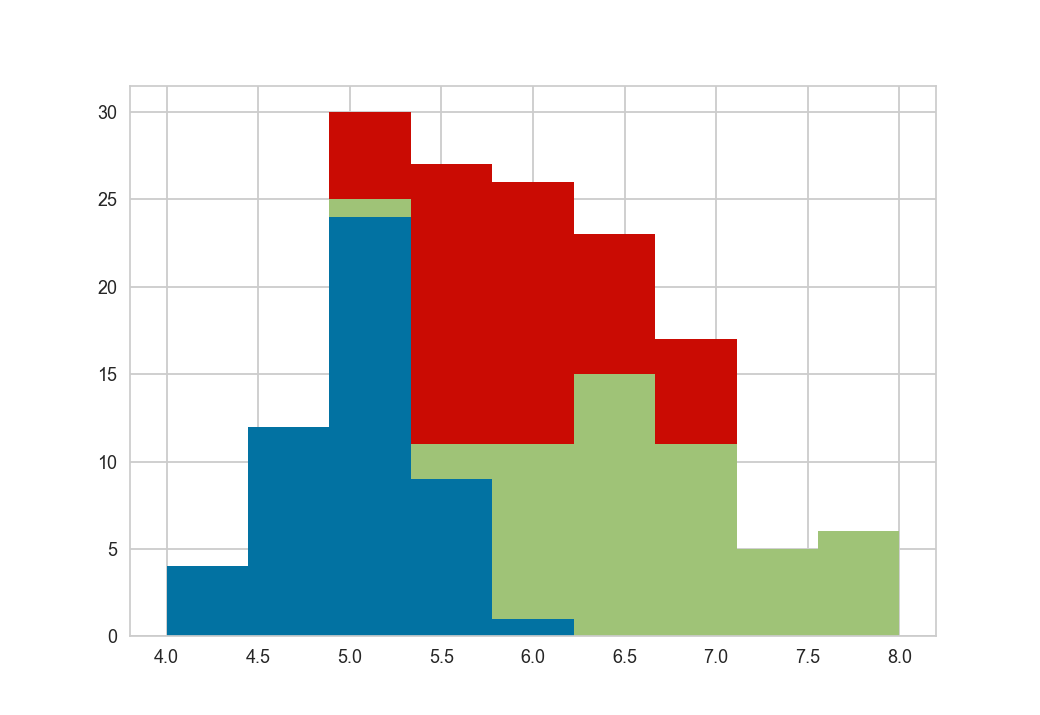

([array([  4.,  12.,  24.,   9.,   1.,   0.,   0.,   0.,   0.]),
  array([  4.,  12.,  25.,  11.,  11.,  15.,  11.,   5.,   6.]),
  array([  4.,  12.,  30.,  27.,  26.,  23.,  17.,   5.,   6.])],
 array([ 4.        ,  4.44444444,  4.88888889,  5.33333333,  5.77777778,
         6.22222222,  6.66666667,  7.11111111,  7.55555556,  8.        ]),
 <a list of 3 Lists of Patches objects>)

In [96]:
from matplotlib.backends.backend_agg import FigureCanvasAgg

vals = pd.to_numeric(iris_df['sepal_length'])
min_val = int(round(min(vals)))
max_val = int(round(max(vals)))

fig = plt.figure()
canvas = FigureCanvasAgg(fig)
plt.hist(grouped_vals, 
        bins=max_val + 1,
        stacked=True,
        range=(min_val,max_val))


<IPython.core.display.Javascript object>


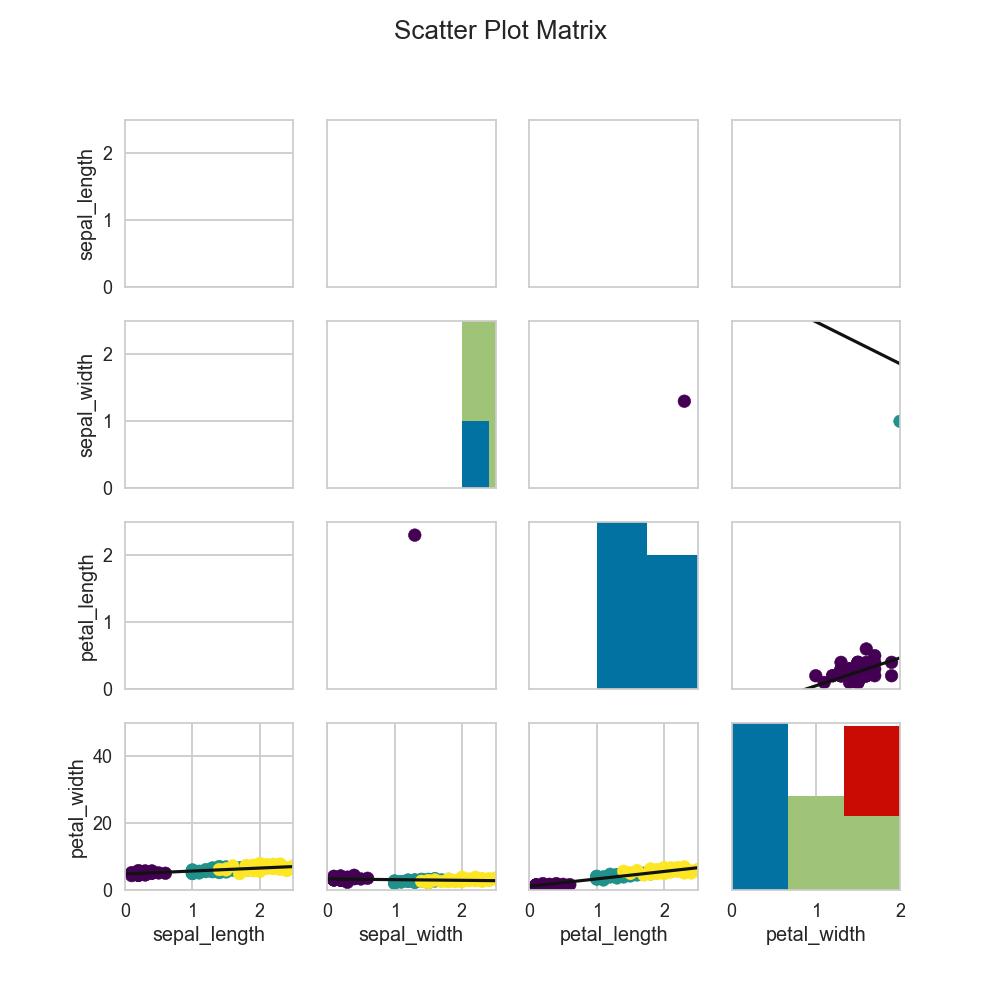

0
0
sepal_length
sepal_length
0
1
sepal_length
sepal_width
0
2
sepal_length
petal_length
0
3
sepal_length
petal_width
1
0
sepal_width
sepal_length
1
1
sepal_width
sepal_width
1
2
sepal_width
petal_length
1
3
sepal_width
petal_width
2
0
petal_length
sepal_length
2
1
petal_length
sepal_width
2
2
petal_length
petal_length
2
3
petal_length
petal_width
3
0
petal_width
sepal_length
3
1
petal_width
sepal_width
3
2
petal_width
petal_length
3
3
petal_width
petal_width


In [107]:
#https://matplotlib.org/faq/usage_faq.html
visualizer = ScatterPlotMatrixVisualizer(features=features, classes=classes)
visualizer.fit(X, y)   # Fit the data to the visualizer
g = visualizer.poof() 